In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np

import sklearn.preprocessing as prepr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pd_dataset = pd.read_csv("IMDB Dataset.csv")
pd_dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
vectorizer = CountVectorizer(binary=True)
dataset = vectorizer.fit_transform(pd_dataset['review'])
len(vectorizer.get_feature_names())

101895

In [7]:
dataset_labels = vectorizer.fit_transform(pd_dataset['sentiment'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.5)
y_train

<25000x2 sparse matrix of type '<class 'numpy.int64'>'
	with 25000 stored elements in Compressed Sparse Row format>

In [9]:
ReLU = nn.ReLU()

class text_nn(nn.Module):
    def __init__(self):
        super(text_nn, self).__init__()
        self.fc1 = nn.Linear(101895, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()

# model creation scheme
# cutting the last hidden layer example
model = text_nn()
fc_layers = nn.Sequential(*list(model.children())[:-2])
model = nn.Sequential(
    fc_layers,
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)
model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=101895, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (1): Linear(in_features=512, out_features=2, bias=True)
  (2): Softmax(dim=1)
)

In [10]:
num_epochs = 2
num_folds = 5
hidden_layers = 3
train_size = 25000
test_size = 25000
batch_size = 50
# valid_losses_array = np.zeros([hidden_layers, num_epochs])
loss_list = []
valid_list = []

criterion = nn.CrossEntropyLoss()

In [11]:
def valid_loss(model, X_valid, y_valid):
    total = 0
    correct = 0
    valid_steps = test_size // batch_size
    for i in range(valid_steps):
        X_batch = torch.tensor(X_valid[i * batch_size:(i + 1) * batch_size].todense(), dtype=torch.float32)
        y_batch = torch.argmax(torch.tensor(y_valid[i * batch_size:(i + 1) * batch_size].todense(), dtype=torch.int8), dim=1)

        out = model(X_batch)
        _, predicted = torch.max(out.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum()
    
    return 100 * correct / total

In [21]:
def cross_valid_train(model, num_layers):
    train_steps = train_size // batch_size - (train_size // num_folds) // batch_size
    # np_losses = np.zeros([num_epochs, num_folds])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    fold = 0
    rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_epochs, random_state=12883823)
    for train, valid in rkf.split(X_train): # train, valid = cross_validation indexes
        X, y = X_train[train], y_train[train]
        X_valid, y_valid = X_train[valid], y_train[valid]

        for i in range(train_steps):
            X_batch = torch.tensor(X[i * batch_size:(i + 1) * batch_size].todense(), dtype=torch.float32)
            y_batch = torch.argmax(torch.tensor(y[i * batch_size:(i + 1) * batch_size].todense(), dtype=torch.int8), dim=1)

            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss_list.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i % batch_size == 0):
                print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
                    .format(fold // num_folds + 1, num_epochs, i, train_steps, loss))

        # np_losses[fold // num_folds, fold % num_folds] = valid_loss(model, X_valid, y_valid)
        fold += 1

In [22]:
model = nn.Sequential(
    nn.Linear(101895, 2),
    nn.Softmax(dim=1)
)    
print(model)
cross_valid_train(model, 1)

Sequential(
  (0): Linear(in_features=101895, out_features=2, bias=True)
  (1): Softmax(dim=1)
)
Epoch [1/2], Step [0/400], Loss: 0.6924487352371216
Epoch [1/2], Step [50/400], Loss: 0.6117116808891296
Epoch [1/2], Step [100/400], Loss: 0.5369144678115845
Epoch [1/2], Step [150/400], Loss: 0.5359147787094116
Epoch [1/2], Step [200/400], Loss: 0.5182104706764221
Epoch [1/2], Step [250/400], Loss: 0.5346419811248779
Epoch [1/2], Step [300/400], Loss: 0.4784109592437744
Epoch [1/2], Step [350/400], Loss: 0.5317893028259277
Epoch [1/2], Step [0/400], Loss: 0.5077049732208252
Epoch [1/2], Step [50/400], Loss: 0.4777146279811859
Epoch [1/2], Step [100/400], Loss: 0.40955474972724915
Epoch [1/2], Step [150/400], Loss: 0.41738396883010864
Epoch [1/2], Step [200/400], Loss: 0.4214268624782562
Epoch [1/2], Step [250/400], Loss: 0.43355298042297363
Epoch [1/2], Step [300/400], Loss: 0.4706030786037445
Epoch [1/2], Step [350/400], Loss: 0.4930161237716675
Epoch [1/2], Step [0/400], Loss: 0.4639529

In [19]:
print('Accuracy on test reviews: %d %%' % valid_loss(model, X_test, y_test))

Accuracy on test reviews: 89 %


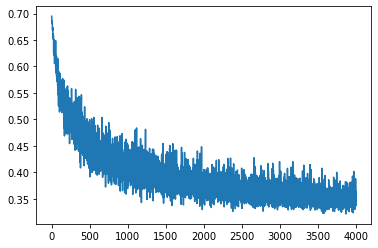

In [20]:
plt.plot(np.arange(len(loss_list)), loss_list)